# Density estimation by reverse KL minimization
## Background
In my previous [post](https://www.kaggle.com/code/runway/gaussian-mixture), I showed how to fit a gaussian mixture model to a set of points $\{x\}$. This activity is called density estimation: estimating the density function of the data generating process via optimizing the fit of some parametric model to the data. In particular, the method we used was maximum likelihood estimation. Interestingly, maximum likelihood estimation is equivalent to minimizing the Kullback-Leibler (KL) divergence between the data distribution $P(x)$ and model distribution $Q(x)$:
\begin{align}
\min_{Q(x)}\quad \mathcal{D}_{KL}(P(x) || Q(x)) = \mathbb{E}_{P(x)}[\log P(x) - \log Q(x)]
\end{align}
You might notice that the second term is the (negative) likelihood. The first term does not play a role in the optimization since we cannot change $P(s)$ by tuning the parameters of $Q(x)$. For a more detailed discussion, I recommend reading this [blog post](https://agustinus.kristia.de/techblog/2017/01/26/kl-mle/).

A logical question is what will happen if we switch the positions of $P(x)$ and $Q(x)$ like:
\begin{align}
\min_{Q(x)}\quad \mathcal{D}_{KL}(Q(x) || P(x)) = \mathbb{E}_{Q(x)}[\log Q(x) - \log P(x)]
\end{align}
This is called the **reverse** KL divergence, as opposed to the previous **forward** KL divergence. The problem now is that the way you tune $Q(x)$ depends on $P(x)$, which we do not know!

## Density ratio estimation
Luckly, there is a method for estimating the ratio $r(x) = \frac{Q(x)}{P(x)}$ from samples, which allows us to replace the objective all together with:
\begin{align}
\min_{Q(x)} \mathbb{E}_{Q(x)}[\log r(x)]
\end{align}

The keys trick is to notice that the problem can be transformed into binary classification. I will just state the result here and refer you to the [awesome blog](https://tiao.io/post/density-ratio-estimation-for-kl-divergence-minimization-between-implicit-distributions/). Let a logistic regression classifier $D(x)$ outputs the probability of whether a sample $x$ comes from $Q(x)$ (labeled as class 1) or $P(x)$ (labeled as class 0), the optimal classifier would output the probability according to:
\begin{align}
D(x = 1) = sigmoid(\log r(x))
\end{align}

This now gives us a pratical procedure for minimizing the reverse KL divergence:
1. Start with some initial initial estimator $Q(x)$, a classifier $D(x)$, and data samples $\{x\}$ labeled as class 0
2. Draw a batch of samples from $Q(x)$ equal to the size of (fake) data samples and label as class 1
3. Train $D(x)$ to discriminate the samlples until optimality
4. Train $Q(x)$ to maximize $\mathbb{E}_{Q(x)}[\log r(x)]$
5. Repeat 2-4

Notice that I am using "real" and "fake" to refer to the data and generated samples. Some readers will know that the problem here is related to [generative adversarial networks](https://arxiv.org/pdf/1610.02920.pdf) (GAN).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed = 0
eps = 1e-6

## Density ratio estimation with logistic regression
We will first do density ratio estimation on a univariate gaussian and then move to reverse KL minimization. We can speculate that the gaussian log density ratio is a quadratic function since its log-density is quadratic.

In [2]:
# generate dataset from a gaussian
torch.manual_seed(seed)

# number of samples from both real and fake distributions
num_samples = 1000

# create true normal distribution
real_mean = torch.tensor([0.])
real_sd = torch.tensor([1.])
real_dist = torch_dist.Normal(real_mean, real_sd)

real_samples = real_dist.sample((num_samples,))

# create fake normal distribution
fake_mean = torch.tensor([0.5])
fake_sd = torch.tensor([2])
fake_dist = torch_dist.Normal(fake_mean, fake_sd)

fake_samples = fake_dist.sample((num_samples, ))

In [3]:
# estimate density ratio with logistic regression
torch.manual_seed(seed)
lr = 0.05
epochs = 100
clf = nn.Linear(3, 1) # parameterizing the log density ratio
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)

data = torch.cat([real_samples, fake_samples], dim=0)
data = torch.cat([torch.ones(len(data), 1), data, data.pow(2)], dim=1) # quadratic function y = a + bx + cx^2
labels = torch.cat([torch.zeros(num_samples, 1), torch.ones(num_samples, 1)], dim=0)

history = []
for e in range(epochs):
    pred = torch.sigmoid(clf(data))
    
    loss = -torch.mean(
        labels * torch.log(pred + eps) + (1 - labels) * torch.log(1 - pred + eps)
    )

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    history.append(loss.data.item())

    if (e + 1) % 10 == 0:
        print(f"{e + 1}, loss: {loss.data.item():.6f}")

10, loss: 0.763600
20, loss: 0.663883
30, loss: 0.608762
40, loss: 0.616695
50, loss: 0.610725
60, loss: 0.610218
70, loss: 0.608836
80, loss: 0.608699
90, loss: 0.608643
100, loss: 0.608625


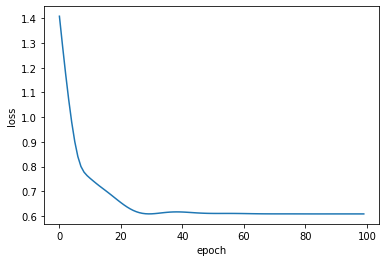

In [4]:
# plot history
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.show()

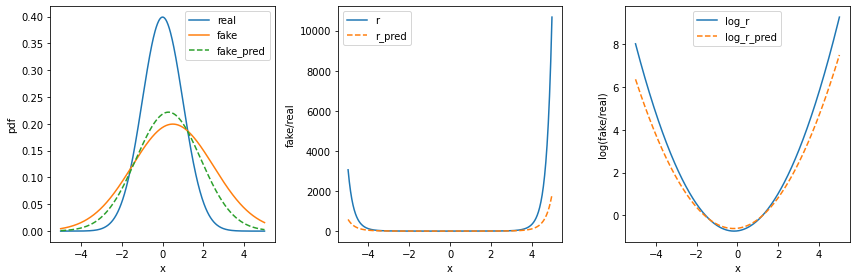

In [5]:
# plot true and predicted density ratios
grid = torch.linspace(-5, 5, 500)

p_real = real_dist.log_prob(grid).exp()
p_fake = fake_dist.log_prob(grid).exp()
r = p_fake / p_real

# predict density ratio
grid_input = torch.stack([torch.ones(len(grid)), grid, grid.pow(2)]).T
with torch.no_grad():
    log_r_pred = clf(grid_input).data.view(-1)
    r_pred = log_r_pred.exp()
    p_fake_pred = r_pred * p_real # reconstruct fake pdf from real pdf and density ratio

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
ax[0].plot(grid, p_real, label="real")
ax[0].plot(grid, p_fake, label="fake")
ax[0].plot(grid, p_fake_pred, "--", label="fake_pred")

ax[1].plot(grid, r, label="r")
ax[1].plot(grid, r_pred, "--", label="r_pred")

ax[2].plot(grid, torch.log(r), label="log_r")
ax[2].plot(grid, log_r_pred, "--", label="log_r_pred")

ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("pdf")

ax[1].legend()
ax[1].set_xlabel("x")
ax[1].set_ylabel("fake/real")

ax[2].legend()
ax[2].set_xlabel("x")
ax[2].set_ylabel("log(fake/real)")

plt.tight_layout()
plt.show()

## Reverse KL minimization with density ratio estimation
In this section, we will use the previous section as a submodule and update $Q(x)$

In [6]:
# generate dataset using the same process
torch.manual_seed(seed)

# number of samples from both real and fake distributions
num_samples = 1000

# create true normal distribution
real_mean = torch.tensor([0.])
real_sd = torch.tensor([1.])
real_dist = torch_dist.Normal(real_mean, real_sd)

real_samples = real_dist.sample((num_samples,))

### A minor technical detail
It is worth mentioning a technical detail since I have written it while testing the code. While I did not find it to matter for this problem, it might be useful for some other problems.

Recall that we are training the distribution $Q(x)$ (let me call it the proposal distribution) to fit $P(x)$ by minimizing $\mathbb{E}_{Q(x)}[\log r(x)]$. Since we are estimating the true $r(x)$ from samples, in reality we only have an estimate $\hat{r}(x)$. Considering the algorithmic procedure, there are now two choices/methods for using $\hat{r}(x)$ during the proposal update:
* Method 1: Directly use the estimator $\hat{r}(x)$ as $\mathbb{E}_{Q(x)}[\log \hat{r}(x)]$
* Method 2: Turn this into an actual KL minimization by first constructing an estimator of the true distribution $\hat{P}(x) = Q_t(x)/\hat{r}(x)$ with proposal from the previous iteration $t$ and the current density ration estimator. Plugging into the KL function:
\begin{align}
\begin{split}
&\mathbb{E}_{Q(x)}[\log Q(x) - \log \frac{Q_t(x)}{r(x)}] \\
&= \mathbb{E}_{Q(x)}[\log r(x)] + \mathcal{D}_{KL}(Q(x) || Q_t(x))
\end{split}
\end{align}
This is sometimes known as the [trust region method](https://arxiv.org/abs/1502.05477), where the second term keeps the new proposal from deviating too much from the previous proposal and thus gain stability in the optimization process.

In [7]:
# reverse kl minimization with density ratio estimation
torch.manual_seed(seed)
lr = 0.05
epochs = 200
e_step = 20 # steps of density ratio estimation
m_step = 1 # steps of kl minimization
method = 1 # proposal update method

clf = nn.Linear(3, 1) # parameterize log density ratio
q_mu = nn.Parameter(torch.randn(1)) # mean of proposal
q_lv = nn.Parameter(0.1 * torch.randn(1)) # log variance of proposal

clf_optimizer = torch.optim.Adam(clf.parameters(), lr=lr)
q_optimizer = torch.optim.Adam([q_mu, q_lv], lr=lr)

history = {"clf": [], "q": []}
for e in range(epochs):
    # set last proposal 
    q_mu_last = q_mu.data.clone()
    q_lv_last = q_lv.data.clone()

    # generate fake samples
    fake_dist = torch.distributions.Normal(q_mu_last, q_lv_last.exp())
    fake_samples = fake_dist.sample((num_samples, ))
    
    # concat data
    data = torch.cat([real_samples, fake_samples], dim=0)
    data = torch.cat([torch.ones(len(data), 1), data, data.pow(2)], dim=1) # quadratic function y = a + bx + cx^2
    labels = torch.cat([torch.zeros(num_samples, 1), torch.ones(num_samples, 1)], dim=0)
    
    # train density ratio estimator
    for i in range(e_step):
        pred = torch.sigmoid(clf(data))
        clf_loss = -torch.mean(
            labels * torch.log(pred + eps) + (1 - labels) * torch.log(1 - pred + eps)
        )

        clf_loss.backward()
        clf_optimizer.step()
        clf_optimizer.zero_grad()
        q_optimizer.zero_grad()
    
    history["clf"].append(clf_loss.data.item())

    # train proposal distribution 
    for i in range(m_step):
        fake_dist = torch.distributions.Normal(q_mu, q_lv.exp())
        fake_samples = fake_dist.rsample((num_samples, ))
        clf_inputs = torch.cat([torch.zeros(num_samples, 1), fake_samples, fake_samples.pow(2)], dim=1)
        
        if method == 1:
            # compute reward method 1
            log_r = clf(clf_inputs)
            q_loss = torch.mean(log_r)
        else:
            # compute reward method 2
            fake_dist_last = torch.distributions.Normal(q_mu_last, q_lv_last.exp())
            log_q_last = fake_dist_last.log_prob(fake_samples)
            log_r = clf(clf_inputs)
            rwd = log_r - log_q_last
            q_loss = torch.mean(rwd) - fake_dist.entropy()

        q_loss.backward()
        q_optimizer.step()
        q_optimizer.zero_grad()
        clf_optimizer.zero_grad()

    history["q"].append(q_loss.data.item())

    if (e + 1) % 10 == 0:
        print(f"{e + 1}, clf_loss: {clf_loss.data.item():.6f}, q_loss: {q_loss.data.item():.6f}")

10, clf_loss: 0.353355, q_loss: 2.825115
20, clf_loss: 0.427102, q_loss: 1.573974
30, clf_loss: 0.512648, q_loss: 0.634320
40, clf_loss: 0.652697, q_loss: -0.064048
50, clf_loss: 0.673472, q_loss: -0.031463
60, clf_loss: 0.687238, q_loss: -0.140176
70, clf_loss: 0.692548, q_loss: -0.219056
80, clf_loss: 0.692753, q_loss: -0.225980
90, clf_loss: 0.692729, q_loss: -0.233658
100, clf_loss: 0.693147, q_loss: -0.215832
110, clf_loss: 0.692947, q_loss: -0.200342
120, clf_loss: 0.693159, q_loss: -0.224121
130, clf_loss: 0.693101, q_loss: -0.218358
140, clf_loss: 0.693076, q_loss: -0.208069
150, clf_loss: 0.692989, q_loss: -0.200220
160, clf_loss: 0.692355, q_loss: -0.195805
170, clf_loss: 0.693135, q_loss: -0.208758
180, clf_loss: 0.692924, q_loss: -0.200784
190, clf_loss: 0.693127, q_loss: -0.204558
200, clf_loss: 0.692951, q_loss: -0.220549


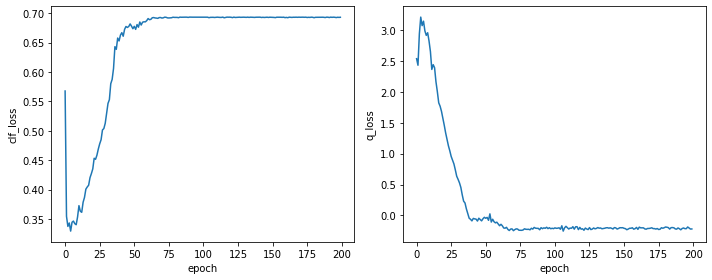

In [8]:
# plot history
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history["clf"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("clf_loss")

ax[1].plot(history["q"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("q_loss")

plt.tight_layout()
plt.show()

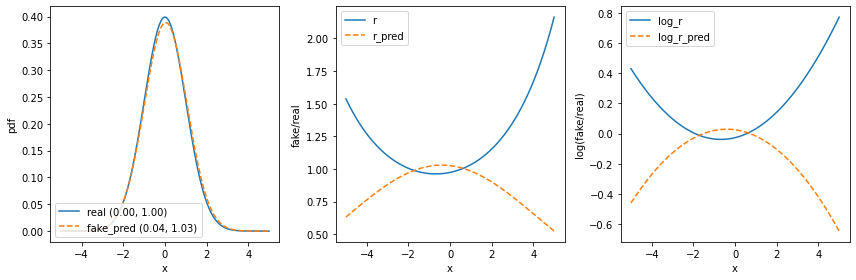

In [9]:
# plot true and predicted density ratios
fake_dist = torch_dist.Normal(q_mu.data, q_lv.exp().data)

grid = torch.linspace(-5, 5, 500)

p_real = real_dist.log_prob(grid).exp()
p_fake_pred = fake_dist.log_prob(grid).exp()
r = p_fake_pred / p_real

# predict density ratio
grid_input = torch.stack([torch.ones(len(grid)), grid, grid.pow(2)]).T
with torch.no_grad():
    log_r_pred = clf(grid_input).data.view(-1)
    r_pred = log_r_pred.exp()

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
ax[0].plot(grid, p_real, label=f"real ({real_mean.item():.2f}, {real_sd.item():.2f})")
ax[0].plot(grid, p_fake_pred, "--", label=f"fake_pred ({q_mu.data.item():.2f}, {q_lv.exp().data.item():.2f})")

ax[1].plot(grid, r, label="r")
ax[1].plot(grid, r_pred, "--", label="r_pred")

ax[2].plot(grid, torch.log(r), label="log_r")
ax[2].plot(grid, log_r_pred, "--", label="log_r_pred")

ax[0].legend(loc="lower left")
ax[0].set_xlabel("x")
ax[0].set_ylabel("pdf")

ax[1].legend()
ax[1].set_xlabel("x")
ax[1].set_ylabel("fake/real")

ax[2].legend()
ax[2].set_xlabel("x")
ax[2].set_ylabel("log(fake/real)")

plt.tight_layout()
plt.show()

Now we have two observations:
1. The training process converged and the classifier became unable to distinguish the real and fake samples. In fact the classfier is just outputing 0.5 (see [chart](https://zhang-yang.medium.com/table-of-cross-entropy-loss-at-different-probabilities-3ec9f47b3b96) for binary cross entropy of 0.69). We can confirm the closeness between the two distributions by looking at the orange dash curve fake_pred. An interesting question to explore next is what is the relationship between this method and GAN, which is known to have unstable training behavior and difficulty of convergence?
2. The density ratio is more accurate near 0 where there is more data and less accurate near the two sides. This is to some extent exaggerated by the small pdf values near the two sides which tend to cause the density ratio to explode.